In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter
from wordcloud import WordCloud

In [176]:
data = pd.read_csv(r"/kaggle/input/datset/Conversation_Dataset.csv")

In [177]:
data.head(1)

conversation_id speaker                  date_time  \
0  2b6544c382e6423b96785c1a135d8e95   agent  2023-09-06T14:33:33+00:00   

                                                text  
0  Good morning, thank you for calling Union Fina...

In [178]:
data.isna().sum()

conversation_id      0
speaker              0
date_time            0
text               630
dtype: int64

In [179]:
data["date_time"] = pd.to_datetime(data["date_time"], format='mixed')
data["date"] = data["date_time"].dt.date
data["time"] = data["date_time"].dt.time
data["timezone"] = data["date_time"].dt.tz
data['timezone'].unique()


array([datetime.timezone.utc], dtype=object)

In [180]:
data[data.text.isna()].groupby(['speaker','date']).size().sort_values(ascending = False).head(5)

speaker   date      
agent     2023-09-11    218
Customer  2023-09-11    217
agent     2023-09-29     21
Customer  2023-09-29     20
          2023-09-10      7
dtype: int64

In [181]:
data[data.text.isna()].groupby(['speaker','time']).size().sort_values(ascending = False).head(5)

speaker   time           
Customer  16:08:59.615384    215
agent     16:08:59.615384    214
          16:21:08.692308     15
Customer  16:21:08.692308     14
          11:40:24.769229      4
dtype: int64

In [182]:
x = data[data.text.isna()].groupby(['speaker','date_time']).size().sort_values(ascending = False).reset_index(name = "empty_value")
x['date_time']=pd.to_datetime(x['date_time']).dt.strftime('%d/%b/%y %H:%m')

In [183]:
x

speaker        date_time  empty_value
0    Customer  11/Sep/23 16:09          215
1       agent  11/Sep/23 16:09          214
2       agent  29/Sep/23 16:09           15
3    Customer  29/Sep/23 16:09           14
4       agent  01/Sep/23 08:09            4
..        ...              ...          ...
153  Customer  20/Sep/23 09:09            1
154  Customer  20/Sep/23 10:09            1
155  Customer  20/Sep/23 11:09            1
156  Customer  20/Sep/23 12:09            1
157  Customer  28/Sep/23 11:09            1

[158 rows x 3 columns]

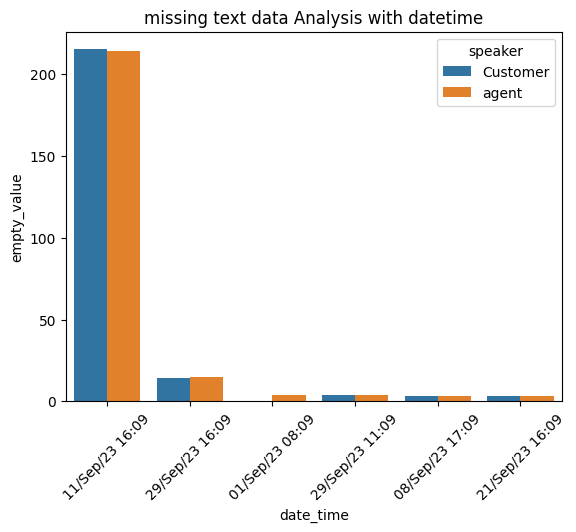

<Figure size 640x480 with 0 Axes>

In [184]:
sns.barplot(x.head(11),x='date_time',y='empty_value', hue = 'speaker')
plt.xticks(rotation = 45)
plt.title("missing text data Analysis with datetime")
plt.figure(100)
plt.show()

In [185]:
data.shape

(5532112, 7)

In [186]:
data.dropna(inplace = True)
data.shape

(5531482, 7)

# STEMMING TEXT : remove stop words | focus on imp info

In [189]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = [word for word in text.split() if word not in ENGLISH_STOP_WORDS]
    return ' '.join(tokens)

data['clean_text'] = data['text'].apply(clean_text)


In [190]:
data.head(2)

conversation_id   speaker  \
0  2b6544c382e6423b96785c1a135d8e95     agent   
1  2b6544c382e6423b96785c1a135d8e95  Customer   

                         date_time  \
0        2023-09-06 14:33:33+00:00   
1 2023-09-06 14:33:41.307692+00:00   

                                                text        date  \
0  Good morning, thank you for calling Union Fina...  2023-09-06   
1  Hi Monroe, my name is Della. I need help manag...  2023-09-06   

              time timezone                                         clean_text  
0         14:33:33      UTC  good morning thank calling union financial mon...  
1  14:33:41.307692      UTC  hi monroe della need help managing bills help ...

In [191]:
data['convo_len']= data.groupby('conversation_id')['clean_text'].transform('count')

In [192]:
data['start_time'] = data.groupby('conversation_id')['date_time'].transform('min')
data['end_time'] = data.groupby('conversation_id')['date_time'].transform('max')

In [193]:
data['start_time'] = pd.to_datetime(data['start_time'], format='mixed')
data['end_time'] = pd.to_datetime(data['end_time'], format='mixed')
data['duration'] = data['end_time']-data['start_time'] 
data['duration']=data['duration'].dt.total_seconds()/60 ### in minss
#data['duration']=data['duration']/60

In [194]:
average_convo_len = data['convo_len'].mean()
average_convo_duration = data['duration'].mean()

# AVERAGE RATE****

In [196]:
average_convo_len,average_convo_duration

(21.907529663840542, 3.5499231368602726)

> checking the **customer satisfication rate** on conversation and duration > average 

In [197]:
new_df = data[(data['convo_len']>=average_convo_len) | (data['duration']>=average_convo_duration)]
last_msg_customer = new_df[new_df['speaker']=='Customer'].sort_values(by=['conversation_id', 'date', 'time']).groupby('conversation_id').tail(1)
contains_thanks=last_msg_customer['clean_text'].str.lower().str.contains(r"thank(s|you|u)")

/tmp/ipykernel_31/284793996.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_thanks=last_msg_customer['clean_text'].str.lower().str.contains(r"thank(s|you|u)")


In [199]:
contains_thanks.value_counts(normalize= True)

clean_text
True     0.524328
False    0.475672
Name: proportion, dtype: float64

### Customer satisfication rate : total conversation ######

In [200]:
data['speaker'].unique()

array(['agent', 'Customer'], dtype=object)

In [201]:
data.conversation_id.nunique()

301821

In [203]:
last_msg = data[data['speaker']=='Customer'].sort_values(by=['conversation_id', 'date', 'time']).groupby('conversation_id').tail(1)
contains_thanks_msg=last_msg['clean_text'].str.lower().str.contains(r"thank(s|you|u|ss)")

/tmp/ipykernel_31/749425596.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_thanks_msg=last_msg['clean_text'].str.lower().str.contains(r"thank(s|you|u|ss)")


> customer Satification at last of converstaion says thanks from full dataset****

In [204]:
contains_thanks_msg.value_counts(normalize=True)

clean_text
True     0.507682
False    0.492318
Name: proportion, dtype: float64

# ANALYSIS** ****

: % of customer saying thanks at end is greater when conversation is greater than average length , and duration . which means the bot needs more details to understand on issue and resolve 

In [205]:
missing_convos = set(data['conversation_id'].unique()) - set(last_msg['conversation_id'].unique())
last_msgs_missing_convo=data[data['conversation_id'].isin(missing_convos)].sort_values(by=['conversation_id', 'date', 'time']).groupby('conversation_id').tail(1)

In [206]:
last_msgs_missing_convo

conversation_id speaker  \
796690   000993261fdd454dac5c4bdf99d5529b   agent   
1112301  000c48e53a9e4d259e0fcdfdb4b60a46   agent   
1032900  0010abaf06474a2d834b45b89805ad02   agent   
501974   00183cddc61b494bb845a60e11b39070   agent   
4697459  0021a1721d21445da3f9b07bd4df532d   agent   
...                                   ...     ...   
2588156  ffc63525b22d4a3c8fd40e7f39d08137   agent   
2498870  ffda3e2445454220945bfd879a90e4cd   agent   
4060     ffdaba7448ac484aa7989fd51ed715cc   agent   
1690030  ffeaa3c05a4240f29ed8d07a007d3295   agent   
2008494  fff7a102982b44b1b718fde771681b3a   agent   

                               date_time  \
796690  2023-09-25 12:12:47.846153+00:00   
1112301 2023-09-25 16:04:05.230769+00:00   
1032900        2023-09-26 15:22:31+00:00   
501974  2023-09-23 10:47:36.076923+00:00   
4697459 2023-09-02 11:51:58.230769+00:00   
...                                  ...   
2588156 2023-09-03 08:55:52.615386+00:00   
2498870        2023-09-11 17:37:11+00:00   
4060    2023-09-25 11:05:59.153846+00:00   
1690030 2023-09-20 11:47:26.384615+00:00   
2008494 2023-09-17 14:57:49.615385+00:00   

                                                      text        date  \
796690   Great, thanks Karen. I'll transfer the call to...  2023-09-25   
1112301  Bye, Brittany. Have a great day! (phone hangs up)  2023-09-25   
1032900  Good morni16086, Winston: Good morning,  thank...  2023-09-26   
501974          Alright, have. Take care. Have a good day.  2023-09-23   
4697459  I understand your frustration, Gracie. But I a...  2023-09-02   
...                                                    ...         ...   
2588156                                           Goodbye.  2023-09-03   
2498870  Hello, thank you for calling Union Financial. ...  2023-09-11   
4060                        Bye, Camila! Have a great day!  2023-09-25   
1690030  You're welcome, Marcella. Is was a pleasure as...  2023-09-20   
2008494                                         Bybye now.  2023-09-17   

                    time timezone  \
796690   12:12:47.846153      UTC   
1112301  16:04:05.230769      UTC   
1032900         15:22:31      UTC   
501974   10:47:36.076923      UTC   
4697459  11:51:58.230769      UTC   
...                  ...      ...   
2588156  08:55:52.615386      UTC   
2498870         17:37:11      UTC   
4060     11:05:59.153846      UTC   
1690030  11:47:26.384615      UTC   
2008494  14:57:49.615385      UTC   

                                                clean_text  convo_len  \
796690                      great thanks karen ll transfer          7   
1112301                 bye brittany great day phone hangs         14   
1032900  good morni winston good morning thank calling ...          1   
501974                               alright care good day          9   
4697459  understand frustration gracie assure doing pro...          7   
...                                                    ...        ...   
2588156                                            goodbye         11   
2498870  hello thank calling union financial sasha assi...          1   
4060                                  bye camila great day          4   
1690030  welcome marcella pleasure assisting questions ...          5   
2008494                                              bybye          8   

                       start_time                         end_time  duration  
796690  2023-09-25 12:11:10+00:00 2023-09-25 12:12:47.846153+00:00  1.630769  
1112301 2023-09-25 15:58:08+00:00 2023-09-25 16:04:05.230769+00:00  5.953846  
1032900 2023-09-26 15:22:31+00:00        2023-09-26 15:22:31+00:00  0.000000  
501974  2023-09-23 10:46:07+00:00 2023-09-23 10:47:36.076923+00:00  1.484615  
4697459 2023-09-02 11:50:49+00:00 2023-09-02 11:51:58.230769+00:00  1.153846  
...                           ...                              ...       ...  
2588156 2023-09-03 08:53:00+00:00 2023-09-03 08:55:52.615386+00:00  2.876923  
2498870 2023-09-1

# Analysis  :call transfer to agent very very low rate # 

In [216]:
agent_df=data[data['speaker']=='agent']
transfer_call = agent_df['clean_text'].str.contains(r"transfer the call|transfer call|transfer agent|technical specialist|technical support")

In [217]:
transfer_call.value_counts(normalize= True)

clean_text
False    0.996129
True     0.003871
Name: proportion, dtype: float64

In [218]:
agent_df[transfer_call]['conversation_id'].nunique()

6155

# #### frustated customers Converstation analysis identifying issues 

In [264]:
df_fc= data[data['clean_text'].str.contains("frustated|frustation|irritated|angrily|angry|ridiculous|phone hangs up|hang up|frustate")& (data['speaker']=='Customer')]

In [265]:
df_fc[["convo_len","duration"]].value_counts()

convo_len  duration 
116        11.646154    34
109        13.546154    34
57         5.769231     28
68         7.369231     20
85         13.069231    18
                        ..
19         4.323077      1
           4.315385      1
           4.315385      1
           4.307692      1
171        11.030769     1
Name: count, Length: 14482, dtype: int64

In [266]:
fc_issues = df_fc["conversation_id"].unique()

In [267]:
len(list(fc_issues)),df_fc.shape

(24358, (33730, 12))

In [270]:
issue_category = ['account_access',"Payment_issue","general_inquiry","Loan_status","Programs","bill_payment","credit_card","debit_card"]

account_access = "account|account number"
Payment_issue = "dispute|transaction|transfer|wire transfer|error"
general_inquiry= "address|marital|verify|branches|currency|ledger|ATM|banking service|banking|overdraft|insurance|chequebook|cheque|deposit|mortage|interest rate|bond|personal information|online banking"
Loan_status = "loans|loan|loan application|loan terms|EMI"
Programs="donation|intiative|policies|investment|referral|referral program|scholarship|reward points"
bill_payment = "bill|pay my bill|online bill pay|electricity|automatic payment|pay bill|bill payment"
credit_card = "credit card|credit card application"
debit_card = "debit card|debit card application"

In [271]:
def set_condition(x):
    conditions =[
    (x['clean_text'].str.contains(account_access)),
    (x['clean_text'].str.contains(Payment_issue)),
    (x['clean_text'].str.contains(general_inquiry)),
    (x['clean_text'].str.contains(Loan_status)),
    (x['clean_text'].str.contains(Programs)),
    (x['clean_text'].str.contains(bill_payment)),
    (x['clean_text'].str.contains(credit_card)),
    (x['clean_text'].str.contains(debit_card))
    ]
    return conditions

In [272]:
df_fc['categories']=np.select(set_condition(df_fc),issue_category,default = "Others")

/tmp/ipykernel_31/2306124388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fc['categories']=np.select(set_condition(df_fc),issue_category,default = "Others")


In [273]:
df_fc['categories'].value_counts()

categories
Others             25180
account_access      3768
general_inquiry     2042
Payment_issue       1760
Loan_status          382
Programs             202
bill_payment         182
credit_card          130
debit_card            84
Name: count, dtype: int64

In [275]:
fc_issues_count= df_fc.groupby('categories')['conversation_id'].nunique().reset_index(name='unique_conversation_count')

In [276]:
fc_issues_count.sort_values(by = ['unique_conversation_count'],inplace = True)

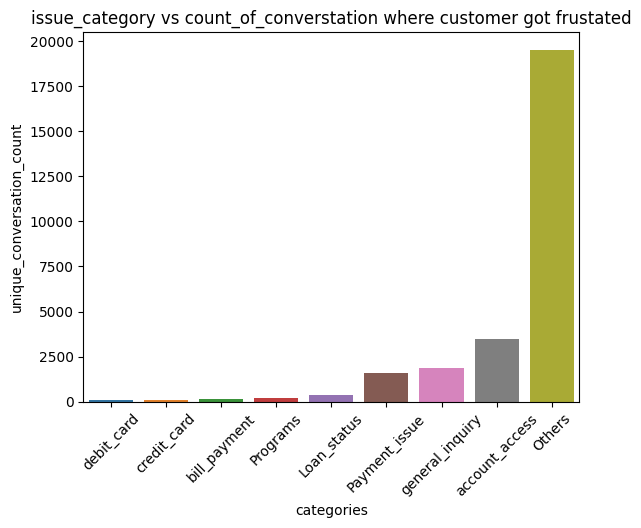

In [277]:
sns.barplot(fc_issues_count, x= "categories",y = 'unique_conversation_count')
plt.xticks(rotation= 45)
plt.title("issue_category vs count_of_converstation where customer got frustated")
plt.show()

> **CUSTOMER ISSUE CATEGORIZATION and counts of unique conversation corresponding to issue****

In [242]:
issues = []

In [278]:
data[data['speaker']=="Customer"].groupby('conversation_id')['clean_text'].head(1).apply(lambda x : issues.append(x))

1          None
18         None
32         None
57         None
129        None
           ... 
5532010    None
5532033    None
5532061    None
5532076    None
5532096    None
Name: clean_text, Length: 298496, dtype: object

In [244]:
issues[:5]

['hi monroe della need help managing bills help set automatic payments',
 'hi mitzi m calling report spam emails received bank tried report website happened',
 'hi barbara avis problem account s levy don t know help resolve',
 'sure thing account number',
 'hi vi m trying access corporate banking services m having trouble logging help']

In [279]:
data_customer= data[data['speaker']=="Customer"]

In [280]:
data_customer['categories']=np.select(set_condition(data_customer),issue_category,default = "Others")

/tmp/ipykernel_31/188272180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_customer['categories']=np.select(set_condition(data_customer),issue_category,default = "Others")


In [282]:
data_customer['categories'].value_counts()

categories
Others             1967758
account_access      361623
general_inquiry     137171
Payment_issue        68978
Loan_status          49147
Programs             30142
credit_card          17666
bill_payment         11538
debit_card            7556
Name: count, dtype: int64

In [283]:
issue_count= data_customer.groupby('categories')['conversation_id'].nunique().reset_index(name='unique_conversation_count').sort_values(by = ['unique_conversation_count'],ascending = False)

In [284]:
issue_count

categories  unique_conversation_count
1           Others                     298221
4   account_access                     196730
8  general_inquiry                      96171
2    Payment_issue                      50458
0      Loan_status                      27762
3         Programs                      20896
6      credit_card                      14264
5     bill_payment                       9195
7       debit_card                       6661

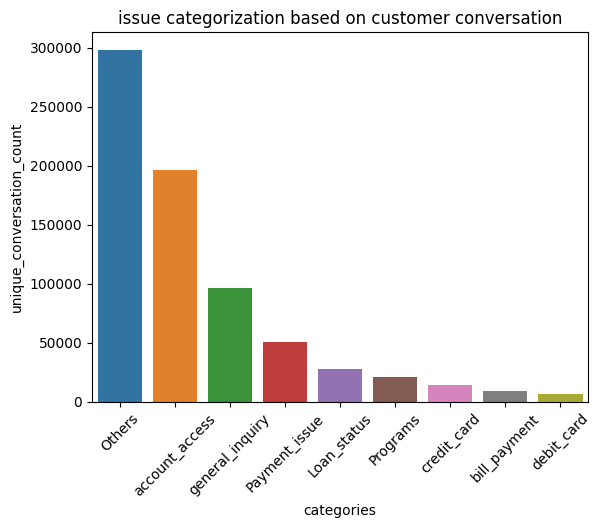

In [285]:
issue_count.sort_values(by = ['unique_conversation_count'],ascending = False,inplace =True)
sns.barplot(issue_count , x = 'categories' , y = 'unique_conversation_count')
plt.title("issue categorization based on customer conversation")
plt.xticks(rotation = 45)
plt.show()

In [286]:
data_customer['Month']=pd.to_datetime(data_customer['date']).dt.strftime('%B')

/tmp/ipykernel_31/3881451280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_customer['Month']=pd.to_datetime(data_customer['date']).dt.strftime('%B')


In [287]:
data_customer["Month"].unique()

array(['September'], dtype=object)

In [288]:
data_customer['week'] = pd.to_datetime(data_customer['date']).dt.to_period('W').apply(lambda r: r.start_time)

/tmp/ipykernel_31/2378124543.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_customer['week'] = pd.to_datetime(data_customer['date']).dt.to_period('W').apply(lambda r: r.start_time)


In [291]:
weekly_issues = data_customer.groupby(['week', 'categories']).size().reset_index(name='count')
weekly_issues_df = weekly_issues.pivot(index = 'week',columns = 'categories',values = 'count')

**WEEK OF SEPTEMEBR VS ISSUES trend : Issue Trend Analysis Over Time******

In [292]:
weekly_issues_df

categories  Loan_status  Others  Payment_issue  Programs  account_access  \
week                                                                       
2023-08-28         5194  203190           7327      3105           37040   
2023-09-04        11914  471748          16414      7212           87247   
2023-09-11        11690  476571          16805      7273           87823   
2023-09-18        11766  475910          16457      7321           87084   
2023-09-25         8583  340339          11975      5231           62429   

categories  bill_payment  credit_card  debit_card  general_inquiry  
week                                                                
2023-08-28          1145         1812         784            14332  
2023-09-04          2881         4280        1910            32650  
2023-09-11          2705         4286        1812            33432  
2023-09-18          2711         4204        1770            32927  
2023-09-25          2096         3084        1280            23830

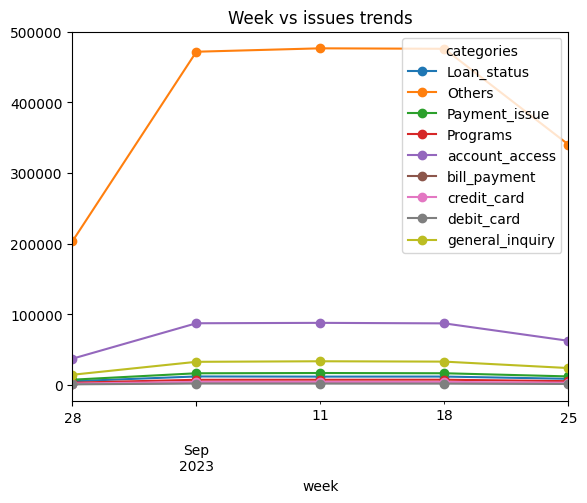

In [293]:
weekly_issues_df.plot(kind= 'line', marker = 'o')
plt.title("Week vs issues trends")
plt.show()

> ACCOUNT ISSUES : ANALYSIS 

In [294]:
data['account_number'] = data['text'].str.extract(r'(\b\d{10}\b)')

In [295]:
repeat_account_no = data['account_number'].value_counts()
repeat_account_no = repeat_account_no[repeat_account_no>1]

In [296]:
data_repeat = data[data['account_number'].isin(repeat_account_no.index)]

In [299]:
data_repeat['categories']=np.select(set_condition(data_repeat),issue_category,default = "Others")

/tmp/ipykernel_31/3369407996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_repeat['categories']=np.select(set_condition(data_repeat),issue_category,default = "Others")


In [300]:
qq= data_repeat.groupby("account_number")["conversation_id"].nunique().reset_index(name="converstaion with repeated issue").sort_values(by = "converstaion with repeated issue",ascending = False)

In [301]:
qq.shape

(75, 2)

In [303]:
qq[qq["converstaion with repeated issue"]>10].head(10)

account_number  converstaion with repeated issue
19     1234567890                            125661
73     9876543210                              3380
29     4234567890                              1406
4      0123456789                               327
26     1876543210                                92
11     1111111111                                33
52     5234567890                                32
54     5432109876                                30
20     1234567891                                23
65     8234567890                                22

# ANALYSIS 3

Random Account being used in conversation also appears some is trying cyber attack using tthe script as it not possible for a custonmer with acc no 1234567890 to have a converstaion 125661 time need to investiagte further 

In [304]:
all_words = [word for reply in agent_data['clean_text'] for word in reply.split()]

# MOST COMMON USE WRDS IN CONVO 

Most common words: [('thank', 759362), ('account', 753802), ('assist', 721105), ('great', 630670), ('financial', 629055), ('today', 604778), ('ll', 600233), ('s', 495374), ('union', 477687), ('like', 460877)]


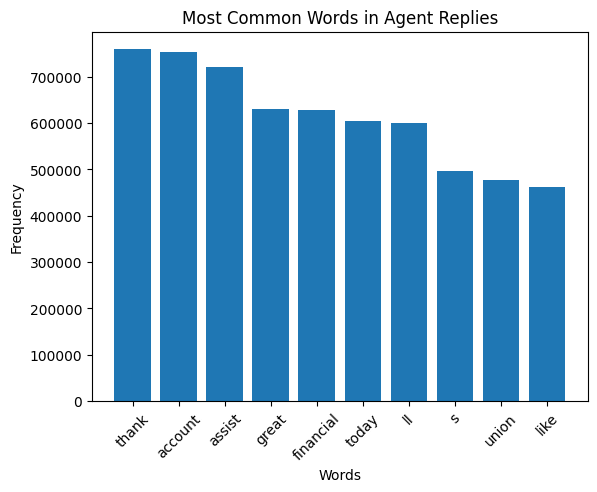

In [306]:
agent_data = data[data['speaker'] == 'agent']

all_words = [word for reply in agent_data['clean_text'] for word in reply.split()]
word_freq = Counter(all_words)

#most common words
print("Most common words:", word_freq.most_common(10))

# Visualize the most common words with a bar chart
common_words = word_freq.most_common(10)
words, counts = zip(*common_words)
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Common Words in Agent Replies')
plt.show()


Most common words: [('thank', 759362), ('account', 753802), ('assist', 721105), ('great', 630670), ('financial', 629055), ('today', 604778), ('ll', 600233), ('s', 495374), ('union', 477687), ('like', 460877)]


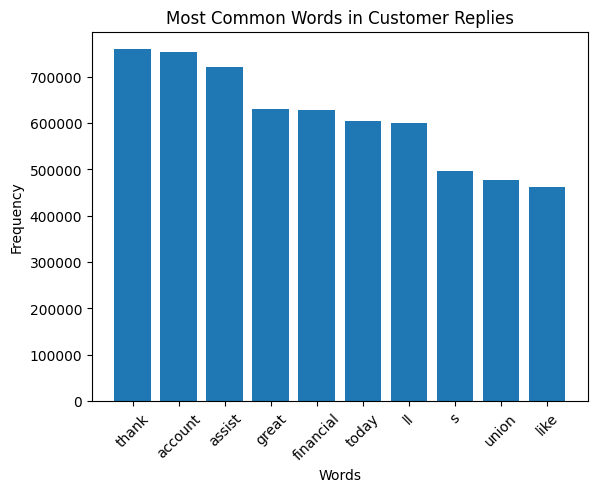

In [307]:
customer_data2 = data[data['speaker'] == 'Customer']

all_words_customer = [word for reply in customer_data2['clean_text'] for word in reply]
word_freq = Counter(all_words)

#most common words
print("Most common words:", word_freq.most_common(10))

# Visualize the most common words with a bar chart
common_words = word_freq.most_common(10)
words, counts = zip(*common_words)
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Common Words in Customer Replies')
plt.show()
